# 2. Predict Brown Dwarf Parameters Using Trained ML Models


In the following steps, you will: 

We will need the following modules from `TelescopeML`:

- *DataMaster*: to prepare the syntheric brown dwarf dataset, load the trained machine learning (ML) models
- *Predictor*: to prepare the observatinal brown dwarf dataset and deploy the trained ML models
- *StatVisAnalyzer*: provide statistical-test and plotting function  
- *IO_utils*: provide functions to load the trained ML models

In [1]:
from TelescopeML.DataMaster import *
from TelescopeML.Predictor import *
from TelescopeML.StatVisAnalyzer import *
from TelescopeML.IO_utils import load_or_dump_trained_model_CNN
np.random.seed(seed=100)

No Bottleneck unit testing available.


Loading BokehJS ...

Loading BokehJS ...

## 2.1 Load the Brown Dwarf spectra and Trained CNNs models


### 2.1.1 Load the Synthetic spectra - training dataset 

<!-- ### 2.1.1 Load the Synthetic spectra - training dataset -->

We computed a low-resolution spectrum ($R$=200) utilizing atmopshric brown dwarfs grid model, [*Sonora-Bobcat*](https://arxiv.org/pdf/2107.07434.pdf) for spectral range $\sim$0.9-2.4 $\mu m$. An open-source atmospheric radiative transfer Python package, [*PICASO*](https://natashabatalha.github.io/picaso/) was employed for generating these datasets. This dataset encompass 30,888 synthetic spectra (or instances or rows). 

Each spectrum has 104 features (or wavelengths in the astrophysics context, i.e., 0.897, 0.906, ..., 2.512~$\mu$m) and 4 parameters:
- gravity ( log$g$ ) 
- temperature ( T$_{eff}$ )
- carbon-to-oxygen ratio ( C/O )
- metallicity ( [M/H] )

In [2]:
# Read the `TelescopeML_reference_data` path

import os  # to check the path  

__reference_data_path__ = os.getenv("TelescopeML_reference_data")
__reference_data_path__

'/Users/egharibn/RESEARCH/ml/projects/TelescopeML_project/reference_data/'

 Load the dataset and check few instances 

In [3]:
train_BD = pd.read_csv(os.path.join(__reference_data_path__, 
                                    'training_datasets', 
                                    'browndwarf_R100_v4_newWL_v3.csv.bz2'), compression='bz2')
train_BD.head(5)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
3,5.0,1100,0.25,-0.3,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
4,5.0,1100,0.25,0.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08


### 2.1.2 Check atmospheric parameters

- gravity ( log$g$ ) 
- temperature ( T$_{eff}$ )
- carbon-to-oxygen ratio ( C/O )
- metallicity ( [M/H] )

Note: one of the columns, *is_augmented*, is indicating whether this is a native dataset or an augmented one. let's just ignore it for now!

In [4]:
output_names = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[output_names].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [5]:
# training_features_labels: they are Wavelengths variables in string format

wavelength_names = [item for item in train_BD.columns.to_list() if item not in output_names]
wavelength_names[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [6]:
# training_features_wl: they are Wavelengths variables 

wavelength_values = [float(item) for item in wavelength_names]
wavelength_values[:10]

[2.512, 2.487, 2.462, 2.438, 2.413, 2.389, 2.366, 2.342, 2.319, 2.296]

In [7]:
wl_synthetic = pd.read_csv(os.path.join(__reference_data_path__, 
                                        'training_datasets', 
                                        'wl.csv'))
wl_synthetic.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


### 2.1.3 Load the trained CNN model

- Load the trained CNN model, which includes:
    - The model parameters to apply it to a given datasets 
    - The training history to check the performance 

In [8]:
trained_CNN_model, trained_CNN_history = load_or_dump_trained_model_CNN(
                                                      output_indicator='tuned_bohb_batch32_v3_1000epoch_out10',
                                                      load_or_dump = 'load')

In [9]:
trained_CNN_model.summary()

Model: "model_1"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_3 (InputLayer)        [(None, 104, 1)]             0         []                            


 Conv__B1_L1 (Conv1D)        (None, 104, 32)              160       ['input_3[0][0]']             


 Conv__B1_L2 (Conv1D)        (None, 104, 128)             16512     ['Conv__B1_L1[0][0]']         


 Conv__B1_L3 (Conv1D)        (None, 104, 288)             147744    ['Conv__B1_L2[0][0]']         


 Conv__B1__MaxPooling1D (Ma  (None, 34, 288)              0         ['Conv__B1_L3[0][0]']         


 xPooling1D)                                                                                      


 Conv__B2_L1 (Conv1D)        (None, 34, 128)              147584    ['Conv__B1__MaxPooling1D[0][0]


                                                                    ']                            


 Conv__B2_L2 (Conv1D)        (None, 34, 288)              147744    ['Conv__B2_L1[0][0]']         


 Conv__B2_L3 (Conv1D)        (None, 34, 512)              590336    ['Conv__B2_L2[0][0]']         


 Conv__B2__MaxPooling1D (Ma  (None, 11, 512)              0         ['Conv__B2_L3[0][0]']         


 xPooling1D)                                                                                      


 flatten_1 (Flatten)         (None, 5632)                 0         ['Conv__B2__MaxPooling1D[0][0]


                                                                    ']                            


 FC1__B1_L1 (Dense)          (None, 256)                  1442048   ['flatten_1[0][0]']           


 FC1__B1_L2 (Dense)          (None, 1024)                 263168    ['FC1__B1_L1[0][0]']          


 FC1__B1_L3 (Dense)          (None, 2304)                 2361600   ['FC1__B1_L2[0][0]']          


 FC1__B1_L3__Dropout (Dropo  (None, 2304)                 0         ['FC1__B1_L3[0][0]']          


 ut)                                                                                              


 input_4 (InputLayer)        [(None, 2)]                  0         []                            


 Concatenated_Layer (Concat  (None, 2306)                 0         ['FC1__B1_L3__Dropout[0][0]', 


 enate)                                                              'input_4[0][0]']             


 FC2__B1_L1 (Dense)          (None, 128)                  295296    ['Concatenated_Layer[0][0]']  


 FC2__B1_L2 (Dense)          (None, 512)                  66048     ['FC2__B1_L1[0][0]']          


 FC2__B1_L3 (Dense)          (None, 1152)                 590976    ['FC2__B1_L2[0][0]']          


 FC2__B1_L4 (Dense)          (None, 2048)                 2361344   ['FC2__B1_L3[0][0]']          


 FC2__B1_L4__Dropout (Dropo  (None, 2048)                 0         ['FC2__B1_L4[0][0]']          


 ut)                                                                                              


 output__gravity (Dense)     (None, 1)                    2049      ['FC2__B1_L4__Dropout[0][0]'] 


 output__c_o_ratio (Dense)   (None, 1)                    2049      ['FC2__B1_L4__Dropout[0][0]'] 


 output__metallicity (Dense  (None, 1)                    2049      ['FC2__B1_L4__Dropout[0][0]'] 


 )                                                                                                


 output__temperature (Dense  (None, 1)                    2049      ['FC2__B1_L4__Dropout[0][0]'] 


 )                                                                                                


Total params: 8438756 (32.19 MB)


Trainable params: 8438756 (32.19 MB)


Non-trainable params: 0 (0.00 Byte)


__________________________________________________________________________________________________


In [10]:
# trained_CNN_history

In [11]:
# train_cnn_model.trained_model_history
plot_ML_model_loss(trained_ML_model_history = trained_CNN_history,
                    title = 'RandState=100: X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

In [12]:
# trained_CNN_history.keys()

### 2.1.4 Load the trained data prosessing Scalers

- Load the trained StandardScalers which were trained and utilized to train the CNNs models:
    - trained_StandardScaler_X_ColWise_MinMax 
    - trained_StandardScaler_y_ColWise 

In [13]:
Load_Save = LoadSave(trained_ML_model_name = 'CNN', ml_method = 'regression')

trained_StandardScaler_X_ColWise_MinMax = Load_Save.load_or_dump_trained_object(
                                                     trained_object = None,
                                                     output_indicator = 'Trained_StandardScaler_X_ColWise_MinMax',
                                                     load_or_dump='load')

trained_StandardScaler_y_ColWise = Load_Save.load_or_dump_trained_object(
                                                     trained_object = None,
                                                     output_indicator = 'Trained_StandardScaler_y_ColWise',
                                                     load_or_dump='load')

---

## 2.2 Predict Brown Dwarf Atmosphric Parameters of HD 3651 B Using the Tuned Radius


In the following, we will deploy the trained CNN models to predict atmospheric parameters. Major steps are: 

1. Define the literature reported data for the object 

2. Instintiate *ObsParameterPredictor* class from *Predictor* module

3. Load the observational Telescope data
    - Replace negative Flam with zero
    - Take the average of neibougrs for Flam_error <= 0
    - Plot_observational_spectra_errorbar_
    
    
4. Process the observational Telescope data
    - Instintiate ProcessObservationalDataset class
    - Define feature_names_synthetic and feature_names_obs


<img src="../figures/ML_pipeline_flowchart_v2.jpg"
     alt="ML pipline"
     style="float: left; margin-right: 10px; width: 90%;" />

### 2.2.1 Tune the Radius Starting from the Literature Radius

In [14]:
HD3651B_BD_literature_info = {
          'bd_name':'HD3651B',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 11.134, 
          'bd_radius_Rjup' : .81,
          'bd_radius_Rjup_tuned': .81} #0.81



 What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius? 

In [15]:

def tune_radius(Rmin = HD3651B_BD_literature_info['bd_radius_Rjup']-0.2, 
                Rmax = HD3651B_BD_literature_info['bd_radius_Rjup']+0.2, 
                dR=0.05,
                Radius_list = None,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = False,
               __plot_stat_results__ = False):
    
    R_list = []
    chi_square_list = []
    p_value_list = []
    random_pred_mean_list = []
 

    for radius in Radius_list if Radius_list else list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR)+1 )):
        print(round(radius,2))
        HD3651B_BD_literature_info['bd_radius_Rjup'] = radius
        
        # brown_dwarf_literature_info = Ross458C_BD_literature_info
        predict = ObserveParameterPredictor(object_name = HD3651B_BD_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl_synthetic = wl_synthetic,# wl_synthetic, 
                                        bd_literature_dic = HD3651B_BD_literature_info,
                                        trained_ML_model=trained_CNN_model,
                                        trained_X_ColWise_MinMax=trained_StandardScaler_X_ColWise_MinMax,
                                        trained_y_ColWise=trained_StandardScaler_y_ColWise,
                                        trained_X_RowWise=None,
                                           )

        predict.load_observational_spectra(
            __plot_observational_spectra_errorbar__=False,
            __replace_zeros_negatives_with_mean__=True,
            __print_results__=False,
            )
        
        predict.Process_Observational_Dataset(
            __print_results__=False,
            F_lambda_obs=None,
            F_lambda_obs_err=None    
                )

        predict.predict_from_random_spectra(random_spectra_num= 3,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_pred_vs_obs_errorbar__= False,
                                             __plot_pred_vs_obs_errorbar_stat_bokeh__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )


        chi_square, p_value =  chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.obs_data_df['Fnu_obs_TOA'], 
                                yerr_obs = predict.obs_data_df['Fnu_obs_TOA_err'],

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = HD3651B_BD_literature_info['bd_radius_Rjup'],
                                __plot_results__ = False,
                                __print_results__ = False)
        
        
        if chi_square:

            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float64(p_value))
            random_pred_mean_list.append(list( predict.dic_random_pred_mean.values() ))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
#     if __plot_stat_results__:
#         plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    tuned_ML_R_param_df = pd.DataFrame(columns=['radius','chi_square','p_value','gravity','temperature','c_o_ratio','metallicity'])
    tuned_ML_R_param_df['radius'] = R_list
    tuned_ML_R_param_df['chi_square'] = chi_square_list
    tuned_ML_R_param_df['p_value'] = p_value_list
    tuned_ML_R_param_df['gravity'] = np.array(random_pred_mean_list).T[0]
    tuned_ML_R_param_df['c_o_ratio'] = np.array(random_pred_mean_list).T[1]
    tuned_ML_R_param_df['metallicity'] = np.array(random_pred_mean_list).T[2]
    tuned_ML_R_param_df['temperature'] = np.array(random_pred_mean_list).T[3]

    return tuned_ML_R_param_df

In [16]:
Rmin = np.round(HD3651B_BD_literature_info['bd_radius_Rjup'],1)- 0.4
Rmax = np.round(HD3651B_BD_literature_info['bd_radius_Rjup'],1)+ 0.4
Radius_list = list( np.linspace(Rmin, Rmax, num=int((Rmax - Rmin) / 0.1) + 1).round(2) )

HD3651B_tuned_ML_R_param_df = tune_radius(
                        Rmin = Rmin, 
                        Rmax = Rmax, 
                        dR = 0.1,
                        Radius_list = Radius_list, #list(np.linspace(.6,1.1,num=51)),
                        brown_dwarf_literature_info = HD3651B_BD_literature_info,
                        __plot_results__=True,
                        __print_results__=True,
                        __plot_stat_results__=True,)

0.4


Radius = 0.40 R_Jup:  𝛘2 = 233.95, p-value = 3.48e-12
0.5


Radius = 0.50 R_Jup:  𝛘2 = 410.57, p-value = 0.00e+00
0.6


Radius = 0.60 R_Jup:  𝛘2 = 110.33, p-value = 2.93e-01
0.7


Radius = 0.70 R_Jup:  𝛘2 = 91.85, p-value = 7.76e-01
0.8


Radius = 0.80 R_Jup:  𝛘2 = 120.13, p-value = 1.19e-01
0.9


Radius = 0.90 R_Jup:  𝛘2 = 281.54, p-value = 0.00e+00
1.0


Radius = 1.00 R_Jup:  𝛘2 = 109.25, p-value = 3.18e-01
1.1


Radius = 1.10 R_Jup:  𝛘2 = 29.78, p-value = 1.00e+00
1.2


Radius = 1.20 R_Jup:  𝛘2 = 118.38, p-value = 1.43e-01


In [17]:
HD3651B_tuned_ML_R_param_df

,radius,chi_square,p_value,gravity,temperature,c_o_ratio,metallicity
0,0.4,233.95,3.480000e-12,4.832331,939.179952,1.844077,-0.496821
1,0.5,410.57,0.000000e+00,4.814885,892.189718,1.847839,-0.499227
2,0.6,110.33,2.930000e-01,4.883448,779.078389,1.667856,-0.506795
3,0.7,91.85,7.760000e-01,4.851073,806.518250,1.968732,-0.491895
4,0.8,120.13,1.190000e-01,4.806926,771.341044,1.652553,-0.507912
5,0.9,281.54,0.000000e+00,4.835071,799.344014,1.504192,-0.518659
6,1.0,109.25,3.180000e-01,5.061557,793.043722,1.996132,-0.500215
7,1.1,29.78,1.000000e+00,4.899004,797.665568,1.829147,-0.502211
8,1.2,118.38,1.430000e-01,4.920628,758.933187,1.676004,-0.507382


In [18]:
HD3651B_tuned_ML_R_param_df.describe()

,radius,chi_square,p_value,gravity,temperature,c_o_ratio,metallicity
count,9.000000,9.000000,9.000000e+00,9.000000,9.000000,9.000000,9.000000
mean,0.800000,167.308889,2.943333e-01,4.878325,815.254872,1.776281,-0.503457
std,0.273861,118.591370,3.612599e-01,0.078795,60.018636,0.161646,0.007788
min,0.400000,29.780000,0.000000e+00,4.806926,758.933187,1.504192,-0.518659
25%,0.600000,109.250000,3.480000e-12,4.832331,779.078389,1.667856,-0.507382
50%,0.800000,118.380000,1.430000e-01,4.851073,797.665568,1.829147,-0.502211
75%,1.000000,233.950000,3.180000e-01,4.899004,806.518250,1.847839,-0.499227
max,1.200000,410.570000,1.000000e+00,5.061557,939.179952,1.996132,-0.491895


0.27 60.02 118.59


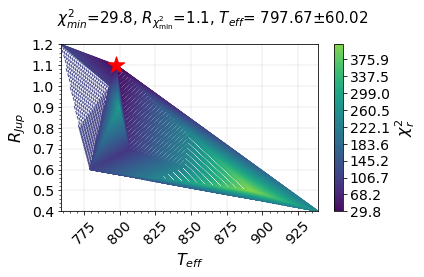

0.27 0.08 118.59


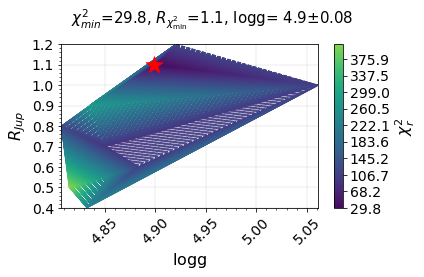

0.27 0.01 118.59


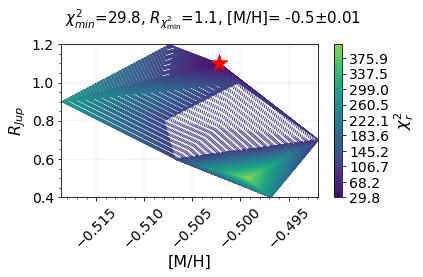

0.27 0.16 118.59


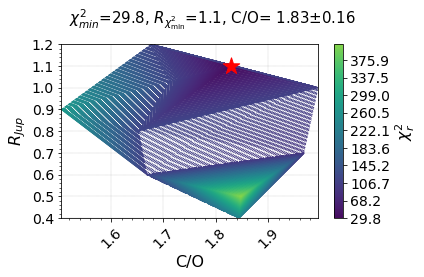

In [19]:
plot_tricontour_chi2_radius(tuned_ML_R_param_df = HD3651B_tuned_ML_R_param_df,
                                list_=['temperature', 'gravity', 'metallicity', 'c_o_ratio'],
                                __save_plot__=False)

---


### 2.2.1 Load the data and process

Define the literature data reported for this object

This data will be used later to: 
- Compare the Literature vs ML predicted results
- Convert the unit of the real observational dataset or fluxes from $F_\lambda$ to $F_\nu$ and $F_\nu^{TOA}$
- Revised the object radius

In [20]:
HD3651B_BD_literature_info = {
          'bd_name':'HD3651B',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 11.134, 
          'bd_radius_Rjup' : 1.19,
          'bd_radius_Rjup_tuned': .81} #0.81

brown_dwarf_literature_info = HD3651B_BD_literature_info



<font size="4"> Instintiate the *ObserveParameterPredictor* class from *Predictor* module </font>

*ObserveParameterPredictor* class performs the following tasks:
- Load the observational datasets
- Process the data including converting their units
- Visualize the data

In [21]:
# brown_dwarf_literature_info 
predict = ObserveParameterPredictor(
                                object_name = HD3651B_BD_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl_synthetic = wl_synthetic, 
                                bd_literature_dic = HD3651B_BD_literature_info,
                                trained_ML_model = trained_CNN_model,
                                trained_X_ColWise_MinMax=trained_StandardScaler_X_ColWise_MinMax,
                                trained_y_ColWise=trained_StandardScaler_y_ColWise,
                                trained_X_RowWise=None,
                                )

<font size="4">  Load the observational Telescope data </font>


In [22]:
predict.load_observational_spectra(
    __plot_observational_spectra_errorbar__=True,
    __replace_zeros_negatives_with_mean__=True,
    __print_results__=True,
    )

------- Observational DataFrame Example ---------
         wl      F_lambda  F_lambda_error  F_lambda_obs  F_lambda_obs_err
0  0.650857  8.606238e-17    4.358173e-17  8.606238e-17      4.358173e-17
1  0.653073  1.771977e-17    3.360256e-17  1.771977e-17      3.360256e-17
2  0.655278  7.300979e-17    3.132892e-17  7.300979e-17      3.132892e-17
3  0.657472  2.569511e-17    2.837585e-17  2.569511e-17      2.837585e-17
4  0.659659  3.786160e-18    2.497690e-17  3.786160e-18      2.497690e-17


Loading BokehJS ...

### 2.2.2 Process the observational Telescope data

In [23]:
predict.Process_Observational_Dataset(
    __print_results__=False,
    F_lambda_obs=None,
    F_lambda_obs_err=None    )

In [24]:
predict.obs_data_df.columns

Index(['wl', 'F_lambda', 'F_lambda_error', 'F_lambda_obs', 'F_lambda_obs_err',
       'Fnu_obs', 'Fnu_obs_err', 'Fnu_obs_TOA', 'Fnu_obs_TOA_err'],
      dtype='object')

<font size="4">  Check the processed Telescope dataset </font>

This dataframe includes the following columns:

- **wl (wavelengths in $\mu m$)**: Wavelengths from the observational dataset.

- **F_lambda ($F_\lambda$)**: Original observational spectral density flux along the wavelength axis.
- **F_lambda_error ($F_\lambda^{error}$)**: Original observational spectral density flux uncertainty along the wavelength axis.
- **F_lambda_obs ($F_\lambda^{obs}$)**: Same as the original F_lambda but with a more descriptive label.
- **F_lambda_obs_err ($F_\lambda^{error, obs}$)**: Same as the original F_lambda_error but with a more descriptive label.
- **Fnu_obs ($F_\nu^{obs}$)**: Observational spectral density flux along the frequency axis (converted from the F_lambda column).
- **Fnu_obs_err ($F_\nu^{error}$)**: Observational spectral density flux uncertainty along the frequency axis (converted from the  F_lambda column).
- **Fnu_obs_TOA ($F_\nu^{obs, abs}$)**: Observational TOA spectral density flux along the frequency axis (converted from the F_lambda column).
- **Fnu_obs_TOA_err ($F_\nu^{obs, abs, error}$)**: Observational TOA spectral density flux uncertainty along the frequency axis (converted from the F_lambda column).



In [25]:
predict.obs_data_df.head(6)

,wl,F_lambda,F_lambda_error,F_lambda_obs,F_lambda_obs_err,Fnu_obs,Fnu_obs_err,Fnu_obs_TOA,Fnu_obs_TOA_err
0,0.650857,8.606238e-17,4.358173e-17,8.606238e-17,4.358173e-17,1.216085e-27,6.158216e-28,1.983163e-08,1.004268e-08
1,0.653073,1.771977e-17,3.360256e-17,1.771977e-17,3.360256e-17,2.520930e-28,4.780520e-28,4.111076e-09,7.795964e-09
2,0.655278,7.300979e-17,3.132892e-17,7.300979e-17,3.132892e-17,1.045711e-27,4.487205e-28,1.705321e-08,7.317633e-09
3,0.657472,2.569511e-17,2.837585e-17,2.569511e-17,2.837585e-17,3.704967e-28,4.091501e-28,6.041977e-09,6.672328e-09
4,0.659659,3.786160e-18,2.497690e-17,3.786160e-18,2.497690e-17,5.495628e-29,3.625408e-28,8.962146e-10,5.912234e-09
5,0.661837,1.798661e-17,2.475434e-17,1.798661e-17,2.475434e-17,2.628032e-28,3.616868e-28,4.285736e-09,5.898308e-09


### 2.2.3 Deploy the Trained ML Models for Prediction: 

<font size="4"> *predict_from_random_spectra* function from *Predictor* class to perform the following tasks: </font>
    
- Generate random spectra based on the observational data

- Deploy the trained ML models to predict the target outputs: 
    - gravity ( log$g$ )
    - temperature ( T$_{eff}$ )
    - carbon-to-oxygen ratio ( C/O )
    - metallicity ( [M/H] )

- Print the results, including:
    - Predicted Targets from Randomly Generated Spectra.
    - Print a summary of descriptive statistics, including the mean, standard deviation, and the shape of a dataset's distribution (percentiles).

- Visualize the results to gain insights about:
    - *Histograms* representing the distribution of the predicted target outputs by the trained ML models.
    - *Boxplots* displaying the first quartile, median, third quartile, and maximum. In a box plot, the box is drawn from the first quartile to the third quartile. A vertical black line goes through the box at the median, and a vertical white line goes through the box to indicate the mean.


******************************

Predicted Targets from Randomly Generated Spectra:

{   'c_o_ratio': 1.7922842025756835,
    'gravity': 4.857903385162354,
    'metallicity': -0.505011385679245,
    'temperature': 742.0279724121094}
******************************

            logg        c_o        met           T
count  10.000000  10.000000  10.000000   10.000000
mean    4.857903   1.792284  -0.505011  742.027972
std     0.172011   0.245937   0.012871   42.790039
min     4.544462   1.500159  -0.520769  694.708496
25%     4.735796   1.510639  -0.518816  703.486450
50%     4.878034   1.964647  -0.499246  732.769257
75%     4.982469   1.988562  -0.495063  773.159149
max     5.111677   1.999956  -0.488801  814.944519


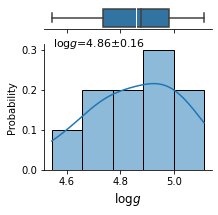

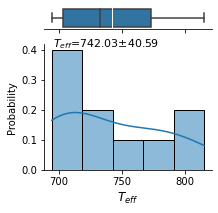

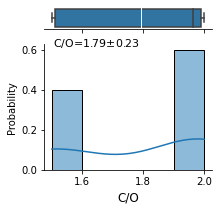

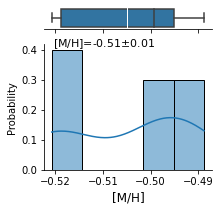

Radius = 1.19 R_Jup:  𝛘2 = 162.69, p-value = 1.62e-04


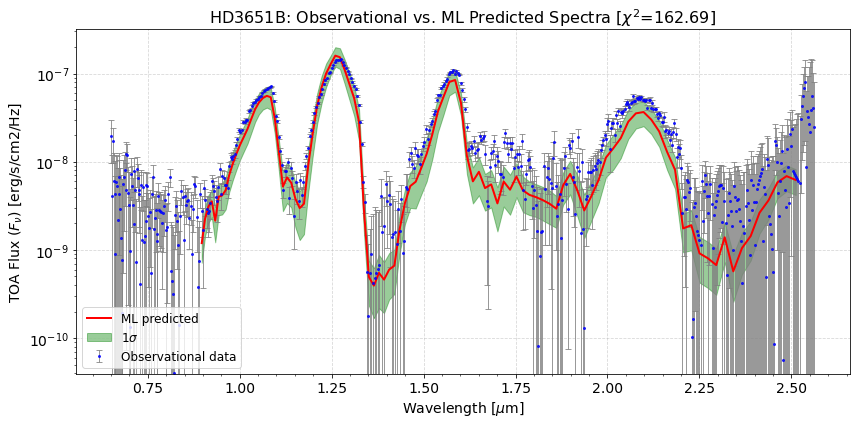

In [26]:
predict.predict_from_random_spectra(random_spectra_num= 10,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= True,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_pred_vs_obs_errorbar__= True,
                                     __plot_pred_vs_obs_errorbar_stat_bokeh__ = False,
                                    __plot_pred_vs_obs_errorbar_stat_matplotlib__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

---